# Deriving how "taints" diffuse across a shareholding graph with matrix factorisation and adaptation of Markov stationary states

In [79]:
import numpy as np
from sympy import Matrix, diag
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Description of problem

Shareholding can be represented as a graph, comprising:
- Nodes of types:
    - Individual; and
    - Company
- Edges with weights representing ownership

In particular certain **Individuals** may have attributes of concern. These could be positive attributes or negative attributes. Either way, business units are interested in how these attributes *diffuse* across **Companies**.

### How would we ordinarily calculate the diffusion of **Individual** attributes to **Companies**?
### Acyclic case

In [80]:
nodes = {"INDIVIDUAL":["A \n(tainted)", "B", "C \n(tainted)"], "COMPANY": ["V","W", "X"]}
edges = [("A \n(tainted)", "V", 0.7), ("B", "V", 0.3), ("V", "W", 0.2), ("C \n(tainted)", "W", 0.8), ("W", "X", 1.0)]

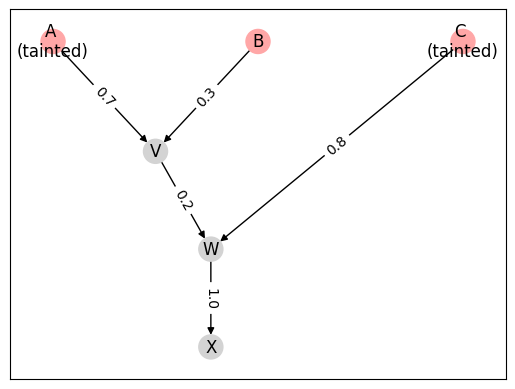

In [81]:
G = nx.DiGraph()
G.add_nodes_from(nodes["INDIVIDUAL"], type="INDIVDUAL")
G.add_nodes_from(nodes["COMPANY"], type="COMPANY")
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
colour_map = ["#ffa7a7" if node in nodes["INDIVIDUAL"] else "#d3d3d3" for node in G]
shape_map = ["s" if node in ["A", "C"] else "o" for node in G]
nx.draw_networkx(G, pos, node_color=colour_map, node_shape="o");
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

In diagram above, directed edge from A to B means that A owns shares in B.
- **red** represents Individuals, who can only own shares in Companies. Nobody can own shares in an Individual.
- **grey** represents a Company who can own shares in another Company, and whose shareholding can be owned by Individuals or Companies.

Also, **A** and **C** are tainted.

How does the taint affect **V**, **W**, and **X**? We simply perform a *depth-first traversal* from tainted nodes, and upon arriving at a **Company** node, we add the adjusted shareholding percentage to that **Company** node. For example, from **A** -> **V**, 0.7 of the taint is transferred. From the path **A** -> **V** onwards, the taint can only be 0.7 maximum, and in the path **A** -> **V** -> **W**, **W** is tainted $0.7 * 0.2 = 0.14$.

# Cyclic case
But things aren't always neat. Consider the cyclic case.

We add an edge from **X** to **V** in <span style="color:red">**red**</span>. This happens in real-life settings, when corporate structures can become convoluted.

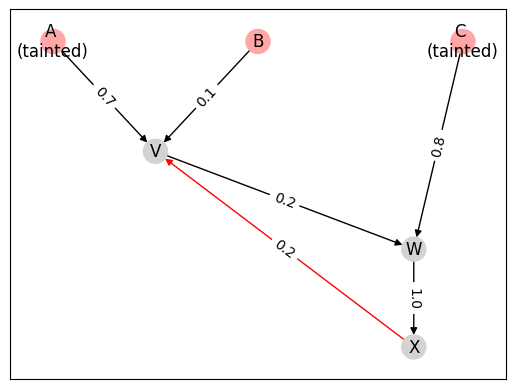

In [82]:
nodes = {"INDIVIDUAL":["A \n(tainted)", "B", "C \n(tainted)"], "COMPANY": ["V","W", "X"]}
edges = [("A \n(tainted)", "V", 0.7), ("B", "V", 0.1), ("V", "W", 0.2), ("C \n(tainted)", "W", 0.8), ("W", "X", 1.0), ("X", "V", 0.2)]

G = nx.DiGraph()
G.add_nodes_from(nodes["INDIVIDUAL"], type="INDIVDUAL")
G.add_nodes_from(nodes["COMPANY"], type="COMPANY")
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
node_colour_map = ["#ffa7a7" if node in nodes["INDIVIDUAL"] else "#d3d3d3" for node in G]
edge_colour_map = ["red" if edge==('X', 'V') else "black" for edge in G.edges]
nx.draw_networkx(G, pos, node_color=node_colour_map, edge_color=edge_colour_map, node_shape="o");
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

The <span style="color:red">**red edge**</span> causes our depth-first traversal to *fail*. The earlier assumption that "from the path *A*->*V* onwards, the taint can only be 0.7 maximum" is false, since **X** has an edge that cycles back to **V**.

### Inspiration from Markov stationary distributions

To solve how the taint from **A** and **C** diffuse, we can take inspiration from Markov stationary distributions. If we represent the graph as an Adjacent Matrix $A$, then by raising $\lim_{n \to \infty}A^n$, we end up with a stationary distribution...

...but hold on! It isn't that simple. There is a catch. How do we express the *taint from Nodes **A** and **C*** in this adjacency matrix?

{('A \n(tainted)', 'V'): Text(84.652, 202.435, '0.7'),
 ('A \n(tainted)', 'A \n(tainted)'): Text(55.154, 242.87, '1.0'),
 ('B', 'V'): Text(143.65, 202.435, '0.1'),
 ('C \n(tainted)', 'W'): Text(260.15, 166.435, '0.8'),
 ('C \n(tainted)', 'C \n(tainted)'): Text(273.15, 242.87, '1.0'),
 ('V', 'W'): Text(180.65, 126.0, '0.2'),
 ('W', 'X'): Text(247.15, 54.0, '1.0'),
 ('X', 'V'): Text(180.65, 90.0, '0.2')}

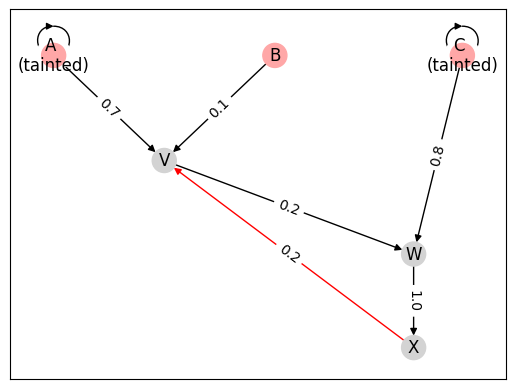

In [83]:
nodes = {
    "INDIVIDUAL": ["A \n(tainted)", "B", "C \n(tainted)"],
    "COMPANY": ["V", "W", "X"],
}
edges = [
    ("A \n(tainted)", "V", 0.7),
    ("B", "V", 0.1),
    ("V", "W", 0.2),
    ("C \n(tainted)", "W", 0.8),
    ("W", "X", 1.0),
    ("X", "V", 0.2),
    ("A \n(tainted)", "A \n(tainted)", 1.0),
    ("C \n(tainted)", "C \n(tainted)", 1.0),
]

G = nx.DiGraph()
G.add_nodes_from(nodes["INDIVIDUAL"], type="INDIVDUAL")
G.add_nodes_from(nodes["COMPANY"], type="COMPANY")
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")
node_colour_map = [
    "#ffa7a7" if node in nodes["INDIVIDUAL"] else "#d3d3d3" for node in G
]
edge_colour_map = ["red" if edge == ("X", "V") else "black" for edge in G.edges]
nx.draw_networkx(
    G, pos, node_color=node_colour_map, edge_color=edge_colour_map, node_shape="o"
)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


What happens, essentially, is that the *taint from **A** and **C** never leaves these tainted nodes*. That is why we have **self-referncing edges from A and C**.

Note that, to answer the question of how the taint diffuses, we do *not* have to bother with edges from Node **B**, because we only care about how the taint diffuses. But we can still include edges from untainted nodes (like Node **B**) as edges emanating from untainted nodes will tend to zero, as $n$ approaches $\infty$.

Our adjacency matrix will look like this:

In [84]:
adj_matrix_sparse = nx.adjacency_matrix(G)
A = Matrix(adj_matrix_sparse.todense());
A

Matrix([
[1.0, 0,   0, 0.7,   0,   0],
[  0, 0,   0, 0.1,   0,   0],
[  0, 0, 1.0,   0, 0.8,   0],
[  0, 0,   0,   0, 0.2,   0],
[  0, 0,   0,   0,   0, 1.0],
[  0, 0,   0, 0.2,   0,   0]])

### Calculating convergence of matrix as $\lim_{n \to \infty}A^n$

One easy way is to raise A to the power of a large number, e.g. $999$. But this seems rather coarse. And how large is enough?

Is there a theoretical approach? Yes there is! Recall **EIGDENDECOMPOSITION OF A MATRIX**:

$Av = \lambda v$, where $v$ is an eigenvector.<br>
Then: $AQ = Q \Lambda$<br>
And:  $A = Q \Lambda Q^{-1}$

In [131]:
Q, D =A.diagonalize()
Q_inv = Q.inverse()

Let's examine the diagonal matrix, **$_Lambda$** or here represented as **$D$**.

In [130]:
D

Matrix([
[1.0, 0,   0,                                          0,                                       0,                                       0],
[  0, 0,   0,                                          0,                                       0,                                       0],
[  0, 0, 1.0,                                          0,                                       0,                                       0],
[  0, 0,   0, 0.341995189335339 + 3.38671635552997e-33*I,                                       0,                                       0],
[  0, 0,   0,                                          0, -0.17099759466767 - 0.296176521936473*I,                                       0],
[  0, 0,   0,                                          0,                                       0, -0.17099759466767 + 0.296176521936473*I]])

We see that 1st and 3rd columns have eigenvalues $1$, and this stays even as $\lim_{n \to \infty}D^n$.

Whereas the 2nd, 4th, 5th columns will converge to $0$.

In [85]:
a = np.array([
    [1,0.9,0,0,0],
    [0,0,0.5,0,0],
    [0,0,0,1,0],
    [0,0.1,0,0,0],
    [0,0,0.5,0,1]
])

a = np.array([
    [1,0.9,0,0,0],
    [0,0,0.5,0,0],
    [0,0.1,0,0,0],
    [0,0.1,0,0,0],
    [0,0,0.5,0,1]
])

{(0, 0): Text(0.46737169747888174, -0.2572021240202003, '1.0'),
 (0, 1): Text(0.3489672092377016, 0.007104630040151938, '0.9'),
 (1, 2): Text(0.0379389506353751, 0.4298702748066898, '0.5'),
 (2, 1): Text(0.0379389506353751, 0.4298702748066898, '0.1'),
 (3, 1): Text(0.1954042162784576, -0.36429430794974793, '0.1'),
 (4, 2): Text(-0.4290900650178984, 0.49289536995984856, '0.5'),
 (4, 4): Text(-0.7034953103100257, 0.3974615744068216, '1.0')}

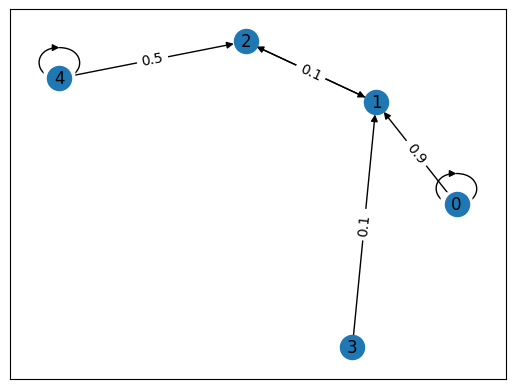

In [86]:
G = nx.from_numpy_matrix(a, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


See http://www.columbia.edu/~ks20/stochastic-I/stochastic-I-MCII.pdf
- Individual node communicates with Company nodes, but not the other way around. i.e. if you start at a Company node, you cannot reach an Individual node.
- 

In [87]:
m = Matrix(a)

In [88]:
m

Matrix([
[1.0, 0.9,   0, 0,   0],
[  0,   0, 0.5, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0,   0, 0.5, 0, 1.0]])

In [89]:
m.pow(999)

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,   0],
[  0,                     0, 3.05493636349973e-650, 0,   0],
[  0, 6.10987272699946e-651,                     0, 0,   0],
[  0, 6.10987272699946e-651,                     0, 0,   0],
[  0,    0.0526315789473684,     0.526315789473684, 0, 1.0]])

In [90]:

a_I = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]], dtype=np.complex_)
M_eigen = Matrix()
for idx, tup in enumerate(m.eigenvects()):
    a_I[idx][idx] = tup[0]
    M_eigen = M_eigen.col_insert(idx,tup[2][0])

In [91]:
(M_eigen**-1)*M_eigen

Matrix([
[1.0,   0, -1.31838984174237e-16, -1.31838984174237e-16,                    0],
[  0, 1.0, -9.84295337433817e-34,  1.48619554847185e-33, 6.84227765783602e-49],
[  0,   0,                   1.0,  1.17360552159731e-33,                    0],
[  0,   0,  1.95789456537934e-33,                   1.0, -1.3684555315672e-48],
[  0,   0, -5.55111512312578e-17,  5.55111512312578e-17,                  1.0]])

In [92]:
P,D=m.diagonalize()

In [93]:
P

Matrix([
[1.0,    0,  0.662291942972039,                1.0,   -0.171928747814649],
[  0,    0, -0.900427692795142, -0.862659113611134, 5.34472197203048e-33],
[  0,    0,  0.402683505982647, -0.385792883888842, 5.77275965394832e-33],
[  0, -1.0,  0.402683505982647, -0.385792883888842, 4.54111163955065e-34],
[  0,    0, -0.164547756159544,  0.248451997499977,   -0.889135243809464]])

In [94]:
P.inverse() == P**-1

True

In [95]:
m.eigenvects()

[(1.00000000000000,
  1,
  [Matrix([
   [1.0],
   [  0],
   [  0],
   [  0],
   [  0]])]),
 (0,
  1,
  [Matrix([
   [   0],
   [   0],
   [   0],
   [-1.0],
   [   0]])]),
 (-0.223606797749979,
  1,
  [Matrix([
   [ 0.662291942972039],
   [-0.900427692795142],
   [ 0.402683505982647],
   [ 0.402683505982647],
   [-0.164547756159544]])]),
 (0.223606797749979,
  1,
  [Matrix([
   [               1.0],
   [-0.862659113611134],
   [-0.385792883888842],
   [-0.385792883888842],
   [ 0.248451997499977]])]),
 (1.00000000000000,
  1,
  [Matrix([
   [  -0.171928747814649],
   [5.34472197203048e-33],
   [5.77275965394832e-33],
   [4.54111163955065e-34],
   [  -0.889135243809464]])])]

In [96]:
D.pow(10)

Matrix([
[1.0, 0,        0,        0,   0],
[  0, 0,        0,        0,   0],
[  0, 0, 3.125e-7,        0,   0],
[  0, 0,        0, 3.125e-7,   0],
[  0, 0,        0,        0, 1.0]])

In [97]:
D_alt = diag(1,0,0,0,1)

In [98]:
0.76760756*0.0685657

0.052631549676691994

In [99]:
P*D_alt*P.inverse()

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,                     0],
[  0, -3.16376117560511e-34, -3.16376117560511e-33, 0, -6.01114623364972e-33],
[  0, -3.41713431771323e-34, -3.41713431771324e-33, 0, -6.49255520365515e-33],
[  0, -2.68807110537889e-35, -2.68807110537889e-34, 0, -5.10733510021989e-34],
[  0,    0.0526315789473684,     0.526315789473684, 0,                   1.0]])

In [100]:
m.pow(9999)

Matrix([
[1.0,      0.947368421052632,      0.473684210526316, 0,   0],
[  0,                      0, 7.07981126105241e-6505, 0,   0],
[  0, 1.41596225221048e-6505,                      0, 0,   0],
[  0, 1.41596225221048e-6505,                      0, 0,   0],
[  0,     0.0526315789473684,      0.526315789473684, 0, 1.0]])

In [101]:
P*D.pow(1000)*P.inverse()

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,                     0],
[  0, -3.16376117560511e-34, -3.16376117560511e-33, 0, -6.01114623364972e-33],
[  0, -3.41713431771323e-34, -3.41713431771324e-33, 0, -6.49255520365515e-33],
[  0, -2.68807110537889e-35, -2.68807110537889e-34, 0, -5.10733510021989e-34],
[  0,    0.0526315789473684,     0.526315789473684, 0,                   1.0]])

In [102]:
I = Matrix(a_I)

In [103]:
I.pow(100)

Matrix([
[1.0, 0,                    0,                    0,   0],
[  0, 0,                    0,                    0,   0],
[  0, 0, 8.88178419700123e-66,                    0,   0],
[  0, 0,                    0, 8.88178419700123e-66,   0],
[  0, 0,                    0,                    0, 1.0]])

In [104]:
m.pow(999).T

Matrix([
[              1.0,                     0,                     0,                     0,                  0],
[0.947368421052632,                     0, 6.10987272699946e-651, 6.10987272699946e-651, 0.0526315789473684],
[0.473684210526316, 3.05493636349973e-650,                     0,                     0,  0.526315789473684],
[                0,                     0,                     0,                     0,                  0],
[                0,                     0,                     0,                     0,                1.0]])

In [105]:
m.jordan_form()

[Matrix([
 [  0, 1.0,   0, -4.02492235949962,  4.02492235949962],
 [  0,   0,   0,  5.47213595499958, -3.47213595499958],
 [  0,   0,   0, -2.44721359549996, -1.55278640450004],
 [1.0,   0,   0, -2.44721359549996, -1.55278640450004],
 [  0,   0, 1.0,               1.0,               1.0]]),
 Matrix([
 [0,   0,   0,                  0,                 0],
 [0, 1.0,   0,                  0,                 0],
 [0,   0, 1.0,                  0,                 0],
 [0,   0,   0, -0.223606797749979,                 0],
 [0,   0,   0,                  0, 0.223606797749979]])]

In [106]:
sym_eignvects = []
for tup in m.eigenvects():
    for v in tup[2]:
        sym_eignvects.append(list(v))
for eigenvect in m.T.eigenvects():
    print(eigenvect)
    print("===")
# print(m.eigenvals())

(1.00000000000000, 1, [Matrix([
[0.686497904853428],
[0.650366436176932],
[0.325183218088466],
[                0],
[                0]])])
===
(-0.223606797749979, 1, [Matrix([
[6.29003810514703e-65],
[   0.408448919408353],
[  -0.913319549133411],
[                   0],
[                   0]])])
===
(0.223606797749979, 1, [Matrix([
[5.4594281676129e-64],
[ -0.628691755035644],
[  -1.40579750115335],
[                  0],
[                  0]])])
===
(0, 1, [Matrix([
[ 1.31007910076992e-64],
[-1.56656453416143e-67],
[   -0.788369347605901],
[    0.788369347605901],
[                    0]])])
===
(1.00000000000000, 1, [Matrix([
[ -0.144979771881992],
[-0.0958561340142084],
[  0.346256606795846],
[                  0],
[  0.788369347605901]])])
===


In [107]:
a_alt = np.array([
    [1,0],
    [2,0]
])
m_alt = Matrix(a_alt)
sym_eignvects = []
for tup in m_alt.eigenvects():
    for v in tup[2]:
        sym_eignvects.append(list(v))
sym_eignvects
print(m_alt.eigenvects())
print(m_alt.eigenvals())

[(0, 1, [Matrix([
[0],
[1]])]), (1, 1, [Matrix([
[1/2],
[  1]])])]
{1: 1, 0: 1}


In [108]:
m.eigenvects()[0][2][0]

Matrix([
[1.0],
[  0],
[  0],
[  0],
[  0]])

In [109]:
m.eigenvects()

[(1.00000000000000,
  1,
  [Matrix([
   [1.0],
   [  0],
   [  0],
   [  0],
   [  0]])]),
 (0,
  1,
  [Matrix([
   [   0],
   [   0],
   [   0],
   [-1.0],
   [   0]])]),
 (-0.223606797749979,
  1,
  [Matrix([
   [ 0.662291942972039],
   [-0.900427692795142],
   [ 0.402683505982647],
   [ 0.402683505982647],
   [-0.164547756159544]])]),
 (0.223606797749979,
  1,
  [Matrix([
   [               1.0],
   [-0.862659113611134],
   [-0.385792883888842],
   [-0.385792883888842],
   [ 0.248451997499977]])]),
 (1.00000000000000,
  1,
  [Matrix([
   [  -0.171928747814649],
   [5.34472197203048e-33],
   [5.77275965394832e-33],
   [4.54111163955065e-34],
   [  -0.889135243809464]])])]

In [110]:
m.T.eigenvects()

[(1.00000000000000,
  1,
  [Matrix([
   [0.686497904853428],
   [0.650366436176932],
   [0.325183218088466],
   [                0],
   [                0]])]),
 (-0.223606797749979,
  1,
  [Matrix([
   [6.29003810514703e-65],
   [   0.408448919408353],
   [  -0.913319549133411],
   [                   0],
   [                   0]])]),
 (0.223606797749979,
  1,
  [Matrix([
   [5.4594281676129e-64],
   [ -0.628691755035644],
   [  -1.40579750115335],
   [                  0],
   [                  0]])]),
 (0,
  1,
  [Matrix([
   [ 1.31007910076992e-64],
   [-1.56656453416143e-67],
   [   -0.788369347605901],
   [    0.788369347605901],
   [                    0]])]),
 (1.00000000000000,
  1,
  [Matrix([
   [ -0.144979771881992],
   [-0.0958561340142084],
   [  0.346256606795846],
   [                  0],
   [  0.788369347605901]])])]

In [111]:
m.left_eigenvects()

[(1.00000000000000,
  1,
  [Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])]),
 (-0.223606797749979,
  1,
  [Matrix([[6.29003810514703e-65, 0.408448919408353, -0.913319549133411, 0, 0]])]),
 (0.223606797749979,
  1,
  [Matrix([[5.4594281676129e-64, -0.628691755035644, -1.40579750115335, 0, 0]])]),
 (0,
  1,
  [Matrix([[1.31007910076992e-64, -1.56656453416143e-67, -0.788369347605901, 0.788369347605901, 0]])]),
 (1.00000000000000,
  1,
  [Matrix([[-0.144979771881992, -0.0958561340142084, 0.346256606795846, 0, 0.788369347605901]])])]

In [112]:
m.left_eigenvects()[0][2][0]

Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])

In [113]:
m.left_eigenvects()[0][2][0]

Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])

In [114]:
m.left_eigenvects()[0][2][0]*m.pow(1)

Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])

In [115]:
m.pow(1001)

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,   0],
[  0,                     0, 1.52746818174986e-651, 0,   0],
[  0, 3.05493636349973e-652,                     0, 0,   0],
[  0, 3.05493636349973e-652,                     0, 0,   0],
[  0,    0.0526315789473684,     0.526315789473684, 0, 1.0]])

In [116]:
m.pow(5)

Matrix([
[1.0, 0.94725,  0.4725, 0,   0],
[  0,       0, 0.00125, 0,   0],
[  0, 0.00025,       0, 0,   0],
[  0, 0.00025,       0, 0,   0],
[  0,  0.0525, 0.52625, 0, 1.0]])

In [117]:
m.pow(1)

Matrix([
[1.0, 0.9,   0, 0,   0],
[  0,   0, 0.5, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0,   0, 0.5, 0, 1.0]])

In [118]:
a_test = np.array([[0.5,0.4,0.1],[0.3,0.4,0.3],[0.2,0.3,0.5]])
m_test = Matrix(a_test)

{(0, 0): Text(0.11555953053798784, 1.0, '0.5'),
 (0, 1): Text(0.419670770044043, 0.2777915859014375, '0.4'),
 (0, 2): Text(-0.36189100477504915, 0.2222084140985624, '0.1'),
 (1, 0): Text(0.419670770044043, 0.2777915859014375, '0.3'),
 (1, 1): Text(0.7237820095500982, -0.44441682819712497, '0.4'),
 (1, 2): Text(-0.05777976526899398, -0.5000000000000001, '0.3'),
 (2, 0): Text(-0.36189100477504915, 0.2222084140985624, '0.2'),
 (2, 1): Text(-0.05777976526899398, -0.5000000000000001, '0.3'),
 (2, 2): Text(-0.8393415400880861, -0.5555831718028752, '0.5')}

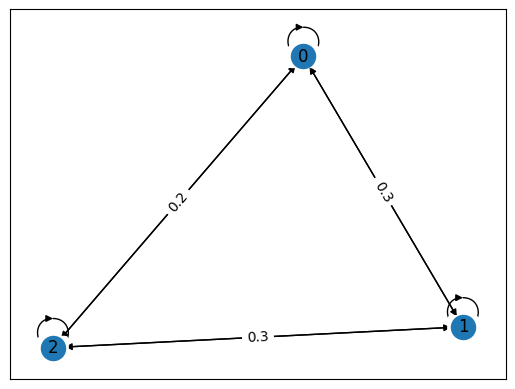

In [119]:
G = nx.from_numpy_matrix(a_test, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


In [120]:
sum(m_test.left_eigenvects()[0][2][0])

1.72355263742428

In [121]:
m_test.left_eigenvects()[0][2][0]/sum(m_test.left_eigenvects()[0][2][0])

Matrix([[0.338709677419355, 0.370967741935484, 0.290322580645161]])

In [122]:
m_test.pow(1000)

Matrix([
[0.338709677419357, 0.370967741935486, 0.290322580645163],
[0.338709677419357, 0.370967741935486, 0.290322580645163],
[0.338709677419357, 0.370967741935486, 0.290322580645163]])